In [1]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

file_path = "C:\\Users\VicariousL\Documents\part1_dataset2_1.dat"
data = np.loadtxt(file_path, dtype = float)

x_data = data[:, 0]
time_interval = x_data[1] - x_data[0]

y1_raw = data[:, 1]/time_interval
y1_data = np.log(y1_raw)
y1_error_raw = data[:, 2]/time_interval
y1_error = y1_error_raw/y1_raw

y2_raw = data[:, 3]/time_interval
y2_data = np.log(y2_raw)
y2_error_raw = data[:, 4]/time_interval
y2_error = y2_error_raw/y2_raw

y3_raw = data[:, 5]/time_interval
y3_data = np.log(y3_raw)
y3_error_raw = data[:, 6]/time_interval
y3_error = y3_error_raw/y3_raw

y4_raw = data[:, 7]/time_interval
y4_data = np.log(y4_raw)
y4_error_raw = data[:, 8]/time_interval
y4_error = y4_error_raw/y4_raw

In [2]:
#CONSTANTS
#All quantities are in standard units

#Difference in chi squared values corresponding to 68, 95, 99% confidence intervals
CI_68 = 2.3
CI_95 = 6.17
CI_99 = 11.8

CI = CI_99 #Change to CI_68 or CI_95 to vary confidence intervals

#Initial Guesses for two isotope scipy fit - May need to be adjusted for different Data
initial_guess1 = [1000, 0.036, 2000, 0.014]
initial_guess2 = [200, 0.036, 500, 0.014]
initial_guess3 = [50, 0.036, 150, 0.014]
initial_guess4 = [12, 0.036, 80, 0.014]

#Step number and initial parameters for MCMC - May need to be adjusted for different Data to achieve suitable jump fractions
step_number = 250000
initial_pars1 = np.array([1000, 0.03, 2000, 0.004])
initial_pars2 = np.array([200, 0.04, 500, 0.005])
initial_pars3 = np.array([50, 0.06, 200, 0.006])
initial_pars4 = np.array([20, 0.05, 60, 0.005])

#Step sizes for MCMC
step1 = np.array([15, 0.001, 15, 0.0001])
step2 = np.array([10, 0.001, 10, 0.0001])
step3 = np.array([8, 0.001, 8, 0.0001])
step4 = np.array([4, 0.001, 4, 0.0001])

#Parameters, Data points and Degrees of freedom for AIC and BIC calculations
N = 100
param = 2 #Parameters for one isotope model
param2 = 4 #Parameters for two isotope model
dof = N - param #DOF for one isotope model
dof2 = N - param2 # DOF for two isotope model

#Isotope Half Lives
Cs_120 = 61.2
Cs_121 = 154.8
Cs_124 = 30.9
Ba_123 = 162
Ba_124 = 660
Ba_125 = 210
Ba_137 = 153.1
Eu_137 = 8.4
Eu_138 = 12.1
Eu_139 = 17.9
Eu_143 = 155.4
W_166 = 19.2
W_168 = 51
W_169 = 76.2
Np_229 = 240
Np_230 = 276
Np_232 = 882

In [3]:
#FUNCTIONS

#Input data, gradient and intercept to return linear fit
def linear(m, x, c):
    return m*x + c

#Input data, initial activity and decay constant to return exponential fit
def exp1(x, A1, lambda1):
    return A1*np.exp(-lambda1*x)

#Two isotope exponential fit
def exp2(x, A1, lambda1, A2, lambda2):
    return A1*np.exp(-lambda1*x) + A2*np.exp(-lambda2*x)

#Two isotope model used for MCMC simulation
def exp2m(x, parameters):
    return parameters[0]*np.exp(-parameters[1]*x) + parameters[2]*np.exp(-parameters[3]*x)

#Input x, y data and errors to return sums used in least squares fit
def chi_sums(x_data, y_data, error):
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    error = np.array(error)
    
    inv_y_error2 = 1/(error*error)
    S = np.sum(inv_y_error2)
    x = x_data * inv_y_error2
    y = y_data * inv_y_error2
    xy = x_data * y_data * inv_y_error2
    xx = x_data * x_data * inv_y_error2
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(xy)
    sum_xx = np.sum(xx)
    
    return S, sum_x, sum_y, sum_xx, sum_xy

#Function to input sums from chi_sums to return gradient for least squares fit
def grad(S, sum_x, sum_y, sum_xx, sum_xy):
    gradient = (S*sum_xy - sum_x*sum_y)/(S*sum_xx - sum_x*sum_x)
    return gradient

#Function to input sums from chi_sums to return intercept for least squares fit
def intercept(S, sum_x, sum_y, sum_xx, sum_xy):
    intercept = (sum_xx*sum_y - sum_x*sum_xy)/(S*sum_xx - sum_x*sum_x)
    return intercept

#Function to input data, fit and errors to return chi squared value
def chi2(data, fit, error):
    x = ((data-fit)**2)/error**2
    chi = np.sum(x)
    return chi

#Function to input chi squared and degrees of freedom to return reduced chi squared
def chi_reduced(chi, dof):
    return chi/dof

#Function to input x, y data, gradient range, intercept range, errors and resolution to return a 2 x 2 grid of chi squared values
#Resolution is the number of m and c values to iterate through
def chi_grid(x, y, m_min, m_max, c_min, c_max, error, resolution):
    m_list = np.linspace(m_min, m_max, resolution) #Range of gradients to iterate over
    c_list = np.linspace(c_min, c_max, resolution) #Range of intercepts to iterate over
    chi2_list = [] #list to hold chi squared values
    
    for m in m_list:
        for c in c_list: #Nested for loop to iterate through every intercept value for each gradient value in m_list
            fit = linear(m, x, c) #Apply a linear fit to the data with corresponding gradient and intercept
            chi2_val = chi2(y, fit, error) #Calculate corresponding chi squared value
            chi2_list.append(chi2_val) #Append chi squared value to list
            #print(f"m: {m}, c: {c}, chi2_val: {chi2_val}")
            
    chi2_grid = np.array(chi2_list).reshape(len(c_list), len(m_list)) #Reshape the chi squared list into a grid of size m_list x c_list
    return m_list, c_list, chi2_list, chi2_grid 

#Function to fix intercept, iterate over a range of gradients and return corresponding chi squared values
def chi_c_fixed(x, y, error, m_min, m_max, fixed_c, resolution):
    varying_m = np.linspace(m_min, m_max, resolution)
    chi2_varying_m = []
    for m in varying_m:
        fit = linear(m, x, fixed_c)
        chi2_val_m = chi2(y, fit, error)
        chi2_varying_m.append(chi2_val_m)
    return varying_m, chi2_varying_m

#Function to fix gradient, iterate over a range of intercepts and return corresponding chi squared values
def chi_m_fixed(x, y, error, c_min, c_max, fixed_m, resolution):
    varying_c = np.linspace(c_min, c_max, resolution)
    chi2_varying_c = []
    for c in varying_c:
        fit = linear(fixed_m, x, c)
        chi2_val_c = chi2(y, fit, error)
        chi2_varying_c.append(chi2_val_c)
    return varying_c, chi2_varying_c

#Function to implement MCMC simulation and estimate best fit parameters
def mcmc(func, x, y, sig, pars0, stepsize, nstep=1e4):
    nstep=int(nstep)
    npars=pars0.shape[0]
    chain=np.zeros((int(nstep),npars))
    chi2=np.zeros(int(nstep))

    chain[0,:]=pars0.copy() #Chain initialized with defined parameters
    mdl=func(x,pars0) #Fit is determined based on initial parameters and a specified function
    chi2[0]=np.sum( (y-mdl)**2/sig**2) #Chi Squared value for the initial fit is calculated
    njump=0
    for i in range(1,nstep):
        pars_new=np.random.normal(chain[i-1,:],stepsize) #New set of parameters are chosen
        mdl=func(x,pars_new) #New fit is determiend based on new parameters
        chi2_new=np.sum( (y-mdl)**2/sig**2) #New chi squared value is calculated
        if (chi2_new > chi2[i-1]):
            p0=np.exp(-(chi2_new-chi2[i-1])/2.) #If new chi squared is higher than previous, the jump probability is set by this function
            p=np.random.uniform(0,1,1) #Random value is selected between 0 and 1, if this random value is less than the previously calculated jump probability, new parameters are selected and the chain jumps
            if  p<=p0:
                chain[i,:]=pars_new
                chi2[i]=chi2_new
                njump=njump+1
            else:
                chain[i,:]=chain[i-1,:] #Otherwise the chain remains in place until the next iteration
                chi2[i]=chi2[i-1]
        else:
            chain[i,:]=pars_new #If the new chi squared value is lower than previous, the chain jumps immediately
            njump=njump+1
            chi2[i]=chi2_new
    print('Jump fraction: %.3f' %(njump/nstep))
    return chain  #sampled parameters during the simulation are returned

#Function to input x data, y data, errors, an initial fit, residuals and iterations to bootstrap gradients and intercepts
#Mean with standard deviations and Median gradients + intercepts are returned
def bootstrap(x_data, y_data, error, initial_fit, initial_resids, iterations):
    
    m_new_list = []
    c_new_list = []
    
    for i in np.arange(1, iterations, 1):
        indices = random.sample(range(0, len(x_data)), k = len(x_data)) #Random numbers selected from list of consecutive numbers ranging from 0 to len(x_data)
        res_sample = [initial_resids[a] for a in indices] #Residuals selected from initial residual list at indices within the indices list
        error = [error[a] for a in indices] #Corresponding errors at same indices selected and held in list
        
        new_fit = initial_fit + res_sample #New fit generated from initial fit + new residuals
        
        S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, new_fit, error) #New chi sums calculated
        
        m_new = grad(S, sum_x, sum_y, sum_xx, sum_xy) #Corresponding gradient and intercepts calculated
        c_new = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
        
        m_new_list.append(m_new) #Gradients and Intercepts appended to lists
        c_new_list.append(c_new)
    
    #Various statistics calculated from gradient and intercept lists
    mean_m = statistics.mean(m_new_list)
    median_m = statistics.median(m_new_list)
    std_m = statistics.stdev(m_new_list)

    mean_c = statistics.mean(c_new_list)
    median_c = statistics.median(c_new_list)
    std_c = statistics.stdev(c_new_list)
    
    return mean_m, median_m, std_m, mean_c, median_c, std_c, m_new_list, c_new_list

#Function to calculate AIC
def AIC(chi, parameters):
    return chi + 2*parameters

#Function to calculate BIC
def BIC(chi, parameters, N):
    return chi + np.log(N)*parameters

#Function to calculate AIC corrected
def AIC_corr(chi, parameters, N):
    return chi + 2*parameters + (2*parameters*(parameters + 1))/(N - parameters - 1)

In [4]:
#FUNCTIONS - DATASET PROCESSING - Previous functions are combined with commands to return salient data and help reduce redundancy

#Function to perform chi squared fit on dataset with errors and return gradient, intercept, residuals and chi squared value
def perform_chi_square_fit(x_data, y_data, y_error):
    S, sum_x, sum_y, sum_xx, sum_xy = chi_sums(x_data, y_data, y_error)
    m = grad(S, sum_x, sum_y, sum_xx, sum_xy)
    c = intercept(S, sum_x, sum_y, sum_xx, sum_xy)
    fit = linear(m, x_data, c)
    residuals = fit - y_data
    chi_square = chi2(y_data, fit, y_error)
    
    return m, c, fit, residuals, chi_square

#Function to return optimal fit parameters using the chi squared grid
def find_optimal_parameters(x_data, y_data, error, m_min, m_max, c_min, c_max, resolution):
    m_list, c_list, chi2_list, chi2_grid = chi_grid(x_data, y_data, m_min, m_max, c_min, c_max, error, resolution)
    min_chi2 = min(chi2_list)
    min_chi2_index = np.argmin(chi2_list)
    min_chi2_value = chi2_list[min_chi2_index]
    m_index, c_index = np.unravel_index(min_chi2_index, chi2_grid.shape)
    
    return m_list, c_list, chi2_list, chi2_grid, min_chi2, min_chi2_index, min_chi2_value, m_index, c_index

def generate_one_isotope_fit(x_data, best_fit_m, best_fit_c):
    return exp1(x_data, np.exp(best_fit_c), -best_fit_m)

#Function to return chi squared values for varying intercepts or gradients while the other is fixed
#Parameter type is selected beforehand, either m or c, to determine which will be fixed and which to iterate over
def chi_squared_fixed_parameter(x_data, y_data, error, param_min, param_max, fixed_param, param_type):
    if param_type == 'm':
        varying_param, chi2_varying_param = chi_c_fixed(x_data, y_data, error, param_min, param_max, fixed_param, 50)
    elif param_type == 'c':
        varying_param, chi2_varying_param = chi_m_fixed(x_data, y_data, error, param_min, param_max, fixed_param, 50)
    else:
        raise ValueError("Invalid parameter type. Use 'm' or 'c'.")
    
    return varying_param, chi2_varying_param

#Function to return the gradient or intercept values when the chi squared value in increased by 2.13, 6.17 or 11.8 from the minimum
#This will return the 68, 95 or 99% confidence intervals on fit parameters calculated from the chi squared grid
def calculate_parameter_uncertainty(varying_param, chi2_varying_param, best_fit_param, CI):
    target_chi = min(chi2_varying_param) + CI
    closest_index = np.argmin(np.abs(chi2_varying_param - target_chi))
    param_at_target = varying_param[closest_index]
    param_unc = np.abs(best_fit_param - param_at_target)
    
    return param_at_target, param_unc

#Function for calculating half lives from decay constants with uncertainties propagated
def calculate_half_life(best_fit_m, m_unc):
    t_half = np.log(2) / -best_fit_m
    t_half_unc = (np.log(2) / best_fit_m**2) * m_unc
    return t_half, t_half_unc

#Function for implementing scipy to fit a two isotope exponential model to data
#Best fit scipy parameters are returned with residuals and chi squared value
def fit_two_isotope_model(x_data, y_data, initial_guess, y_error):
    parameters, covariance = scipy.optimize.curve_fit(exp2, x_data, y_data, p0=initial_guess, sigma=y_error)
    A1, lambda1, A2, lambda2 = parameters
    two_isotope_fit = exp2(x_data, A1, lambda1, A2, lambda2)
    two_isotope_res = two_isotope_fit - y_data
    chi2_two_isotope = chi2(y_data, two_isotope_fit, y_error)
    return parameters, two_isotope_fit, two_isotope_res, chi2_two_isotope

#Function for performing MCMC - initial parameters taken from fit_two_isotope_model function i.e scipy fits
#The median parameters with 16 - 84% CIs are returned
#First 10% of values are discarded as a burn in
def perform_mcmc(x_data, y_raw, y_error_raw, initial_pars, step, step_number, model_func):
    unc_mcmc = mcmc(model_func, x_data, y_raw, y_error_raw, initial_pars, step, step_number)

    remove_index = int(len(unc_mcmc) * 0.1)
    unc_mcmc = unc_mcmc[remove_index:]
    step_no = list(range(remove_index, step_number))

    isotope1_mcmc_c = statistics.median(unc_mcmc[:, 0])
    isotope1_mcmc_m = statistics.median(unc_mcmc[:, 1])
    isotope2_mcmc_c = statistics.median(unc_mcmc[:, 2])
    isotope2_mcmc_m = statistics.median(unc_mcmc[:, 3])

    isotope1_percentile_16_c = np.percentile(unc_mcmc[:, 0], 16)
    isotope1_percentile_84_c = np.percentile(unc_mcmc[:, 0], 84)
    isotope1_percentile_16_m = np.percentile(unc_mcmc[:, 1], 16)
    isotope1_percentile_84_m = np.percentile(unc_mcmc[:, 1], 84)

    isotope2_percentile_16_c = np.percentile(unc_mcmc[:, 2], 16)
    isotope2_percentile_84_c = np.percentile(unc_mcmc[:, 2], 84)
    isotope2_percentile_16_m = np.percentile(unc_mcmc[:, 3], 16)
    isotope2_percentile_84_m = np.percentile(unc_mcmc[:, 3], 84)

    isotope1_CI_c = [np.abs(isotope1_mcmc_c - isotope1_percentile_16_c), np.abs(isotope1_mcmc_c - isotope1_percentile_84_c)]
    isotope1_CI_m = [np.abs(isotope1_mcmc_m - isotope1_percentile_16_m), np.abs(isotope1_mcmc_m - isotope1_percentile_84_m)]
    isotope2_CI_c = [np.abs(isotope2_mcmc_c - isotope2_percentile_16_c), np.abs(isotope2_mcmc_c - isotope2_percentile_84_c)]
    isotope2_CI_m = [np.abs(isotope2_mcmc_m - isotope2_percentile_16_m), np.abs(isotope2_mcmc_m - isotope2_percentile_84_m)]

    return isotope1_mcmc_c, isotope1_mcmc_m, isotope2_mcmc_c, isotope2_mcmc_m, isotope1_CI_c, isotope1_CI_m, isotope2_CI_c, isotope2_CI_m, unc_mcmc

#Function for calculating half lives from decay constants determined via MCMC, with uncertainties propagated
def calculate_half_lives(mcmc_params, mcmc_ci):
    t_half = np.log(2) / mcmc_params
    t_half_unc = (np.log(2) / mcmc_params**2) * np.array(mcmc_ci)
    return t_half, t_half_unc

#Function for returning reduced chi squared, AIC, AIC corrected and BIC values 
def calculate_statistics(min_chi2, parameters, N):
    chi_red = chi_reduced(min_chi2, N - parameters)
    AIC_value = AIC(min_chi2, parameters)
    AIC_corr_value = AIC_corr(min_chi2, parameters, N)
    BIC_value = BIC(min_chi2, parameters, N)
    return chi_red, AIC_value, AIC_corr_value, BIC_value

In [5]:
#Dataset 1
#One Isotope
#Initial least squares linear fit performed on Ln Counts vs Ln Time, to estimate fit parameters
m1, c1, fit1, res1, chi2_1 = perform_chi_square_fit(x_data, y1_data, y1_error) 

#Uncertainties in the initial fit are determined via bootstrapping
boot_initial1 = bootstrap(x_data, y1_data, y1_error, fit1, res1, 1000)
m_initial_unc1, c_initial_unc1 = boot_initial1[2], boot_initial1[5]

#The uncertainties in initial fit parameters multiplied by 5 are used as the parameter range in the chi squared grid
m1_min, m1_max, c1_min, c1_max = m1-(5*m_initial_unc1), m1+(5*m_initial_unc1), c1-(5*c_initial_unc1), c1+(5*c_initial_unc1) 

#Optimal parameters are determined using a grid system, between a range of parameters defined above
m1_list, c1_list, chi2_list1, chi2_grid1, min_chi2_1, min_chi2_index1, min_chi2_value1, m1_index, c1_index = find_optimal_parameters(x_data, y1_data, y1_error, m1_min, m1_max, c1_min, c1_max, 50)

#Best fit parameters are returned
best_fit_m1 = m1_list[m1_index]
best_fit_c1 = c1_list[c1_index]

#Exponential fit generated from best fit parameters and residuals calculated
one_isotope_fit1 = generate_one_isotope_fit(x_data, best_fit_m1, best_fit_c1)
one_isotope_res1 = one_isotope_fit1 - y1_raw

#Either gradient or intercept are fixed while the other is varied between the range defined above, and corresponding chi squared values are returned
varying_m1, chi2_varying_m1 = chi_squared_fixed_parameter(x_data, y1_data, y1_error, m1_min, m1_max, best_fit_c1, 'm')
varying_c1, chi2_varying_c1 = chi_squared_fixed_parameter(x_data, y1_data, y1_error, c1_min, c1_max, best_fit_m1, 'c')

#Gradient or Intercept value corresponding to a change in chi squared of either 2.13, 6.17 or 11.8 are returned. 
#These changes in chi squared values correspond to the 68, 95 and 99% confidence intervals
#CI can be adjusted in the Constants section change the confidence interval being calculated
m1_at_target, m1_unc = calculate_parameter_uncertainty(varying_m1, chi2_varying_m1, best_fit_m1, CI)
c1_at_target, c1_unc = calculate_parameter_uncertainty(varying_c1, chi2_varying_c1, best_fit_c1, CI)

#Half lives are calculated from best fit gradients/decay constants, and uncertainties propagated
t_half1 = np.log(2)/-best_fit_m1
t_half_unc1 = (np.log(2)/best_fit_m1**2)*m1_unc

#Dataset 1
#Two Isotope
#Scipy is used to fit a two isotope exoponential decay function to the data, provided with an initial guess based on one isotope fit parameters
parameters1, two_isotope_fit1, two_isotope_res1, chi2_two_isotope1 = fit_two_isotope_model(x_data, y1_raw, initial_guess1, y1_error_raw)
A1_1, lambda1_1, A2_1, lambda2_1 = parameters1

#MCMC method is used to determine best fit parameters and uncertainties
result_dataset1 = perform_mcmc(x_data, y1_raw, y1_error_raw, initial_pars1, step1, step_number, exp2m)
isotope1_mcmc_c1, isotope1_mcmc_m1, isotope2_mcmc_c1, isotope2_mcmc_m1, isotope1_CI_c1, isotope1_CI_m1, isotope2_CI_c1, isotope2_CI_m1, chain1 = result_dataset1
mcmc_fit1 = exp2(x_data, isotope1_mcmc_c1, isotope1_mcmc_m1, isotope2_mcmc_c1, isotope2_mcmc_m1)
mcmc_chi2_min1 = chi2(y1_raw, mcmc_fit1, y1_error_raw)

#Half lives for the two isotopes are calculated from the two decay constants calculated above, with uncertainties propagated
iso1_t_half1, iso1_t_half_unc1 = calculate_half_lives(isotope1_mcmc_m1, isotope1_CI_m1)
iso2_t_half1, iso2_t_half_unc1 = calculate_half_lives(isotope2_mcmc_m1, isotope2_CI_m1)

#Reduced Chi squared, AIC, AIC corrected and BIC are calculated for the one isotope and two isotope fits
stats_1 = calculate_statistics(min_chi2_1, param, N)
chi_reduced_1, AIC_1, AIC_corr_1, BIC_1 = stats_1
stats_two_isotope_1 = calculate_statistics(mcmc_chi2_min1, param2, N)
two_isotope_chi_reduced_1, two_isotope_AIC_1, two_isotope_AIC_corr_1, two_isotope_BIC_1 = stats_two_isotope_1

#Process Repeated for the other datasets

#Dataset 2
#One Isotope
m2, c2, fit2, res2, chi2_2 = perform_chi_square_fit(x_data, y2_data, y2_error)
boot_initial2 = bootstrap(x_data, y2_data, y2_error, fit2, res2, 1000)
m_initial_unc2, c_initial_unc2 = boot_initial2[2], boot_initial2[5]
m2_min, m2_max, c2_min, c2_max = m2-(5*m_initial_unc2), m2+(5*m_initial_unc2), c2-(5*c_initial_unc2), c2+(5*c_initial_unc2) 
m2_list, c2_list, chi2_list2, chi2_grid2, min_chi2_2, min_chi2_index2, min_chi2_value2, m2_index, c2_index = find_optimal_parameters(x_data, y2_data, y2_error, m2_min, m2_max, c2_min, c2_max, 50)
best_fit_m2 = m2_list[m2_index]
best_fit_c2 = c2_list[c2_index]
one_isotope_fit2 = generate_one_isotope_fit(x_data, best_fit_m2, best_fit_c2)
one_isotope_res2 = one_isotope_fit2 - y2_raw
varying_m2, chi2_varying_m2 = chi_squared_fixed_parameter(x_data, y2_data, y2_error, m2_min, m2_max, best_fit_c2, 'm')
varying_c2, chi2_varying_c2 = chi_squared_fixed_parameter(x_data, y2_data, y2_error, c2_min, c2_max, best_fit_m2, 'c')
m2_at_target, m2_unc = calculate_parameter_uncertainty(varying_m2, chi2_varying_m2, best_fit_m2, CI)
c2_at_target, c2_unc = calculate_parameter_uncertainty(varying_c2, chi2_varying_c2, best_fit_c2, CI)
t_half2 = np.log(2)/-best_fit_m2
t_half_unc2 = (np.log(2)/best_fit_m2**2)*m2_unc

#Dataset 2
#Two Isotope
parameters2, two_isotope_fit2, two_isotope_res2, chi2_two_isotope2 = fit_two_isotope_model(x_data, y2_raw, initial_guess2, y2_error_raw)
A1_2, lambda1_2, A2_2, lambda2_2 = parameters2
result_dataset2 = perform_mcmc(x_data, y2_raw, y2_error_raw, initial_pars2, step2, step_number, exp2m)
isotope1_mcmc_c2, isotope1_mcmc_m2, isotope2_mcmc_c2, isotope2_mcmc_m2, isotope1_CI_c2, isotope1_CI_m2, isotope2_CI_c2, isotope2_CI_m2, chain2 = result_dataset2
mcmc_fit2 = exp2(x_data, isotope1_mcmc_c2, isotope1_mcmc_m2, isotope2_mcmc_c2, isotope2_mcmc_m2)
mcmc_chi2_min2 = chi2(y2_raw, mcmc_fit2, y2_error_raw)
iso1_t_half2, iso1_t_half_unc2 = calculate_half_lives(isotope1_mcmc_m2, isotope1_CI_m2)
iso2_t_half2, iso2_t_half_unc2 = calculate_half_lives(isotope2_mcmc_m2, isotope2_CI_m2)
stats_2 = calculate_statistics(min_chi2_2, param, N)
chi_reduced_2, AIC_2, AIC_corr_2, BIC_2 = stats_2
stats_two_isotope_2 = calculate_statistics(mcmc_chi2_min2, param2, N)
two_isotope_chi_reduced_2, two_isotope_AIC_2, two_isotope_AIC_corr_2, two_isotope_BIC_2 = stats_two_isotope_2

#Dataset 3
#One Isotope
m3, c3, fit3, res3, chi2_3 = perform_chi_square_fit(x_data, y3_data, y3_error)
boot_initial3 = bootstrap(x_data, y3_data, y3_error, fit3, res3, 1000)
m_initial_unc3, c_initial_unc3 = boot_initial3[2], boot_initial3[5]
m3_min, m3_max, c3_min, c3_max = m3-(5*m_initial_unc3), m3+(5*m_initial_unc3), c3-(5*c_initial_unc3), c3+(5*c_initial_unc3) 
m3_list, c3_list, chi2_list3, chi2_grid3, min_chi2_3, min_chi2_index3, min_chi2_value3, m3_index, c3_index = find_optimal_parameters(x_data, y3_data, y3_error, m3_min, m3_max, c3_min, c3_max, 50)
best_fit_m3 = m3_list[m3_index]
best_fit_c3 = c3_list[c3_index]
one_isotope_fit3 = generate_one_isotope_fit(x_data, best_fit_m3, best_fit_c3)
one_isotope_res3 = one_isotope_fit3 - y3_raw
varying_m3, chi2_varying_m3 = chi_squared_fixed_parameter(x_data, y3_data, y3_error, m3_min, m3_max, best_fit_c3, 'm')
varying_c3, chi2_varying_c3 = chi_squared_fixed_parameter(x_data, y3_data, y3_error, c3_min, c3_max, best_fit_m3, 'c')
m3_at_target, m3_unc = calculate_parameter_uncertainty(varying_m3, chi2_varying_m3, best_fit_m3, CI)
c3_at_target, c3_unc = calculate_parameter_uncertainty(varying_c3, chi2_varying_c3, best_fit_c3, CI)
t_half3 = np.log(2)/-best_fit_m3
t_half_unc3 = (np.log(2)/best_fit_m3**2)*m3_unc

#Dataset 3
#Two Isotope
parameters3, two_isotope_fit3, two_isotope_res3, chi2_two_isotope3 = fit_two_isotope_model(x_data, y3_raw, initial_guess3, y3_error_raw)
A1_3, lambda1_3, A2_3, lambda2_3 = parameters3
result_dataset3 = perform_mcmc(x_data, y3_raw, y3_error_raw, initial_pars3, step3, step_number, exp2m)
isotope1_mcmc_c3, isotope1_mcmc_m3, isotope2_mcmc_c3, isotope2_mcmc_m3, isotope1_CI_c3, isotope1_CI_m3, isotope2_CI_c3, isotope2_CI_m3, chain3 = result_dataset3
mcmc_fit3 = exp2(x_data, isotope1_mcmc_c3, isotope1_mcmc_m3, isotope2_mcmc_c3, isotope2_mcmc_m3)
mcmc_chi2_min3 = chi2(y3_raw, mcmc_fit3, y3_error_raw)
iso1_t_half3, iso1_t_half_unc3 = calculate_half_lives(isotope1_mcmc_m3, isotope1_CI_m3)
iso2_t_half3, iso2_t_half_unc3 = calculate_half_lives(isotope2_mcmc_m3, isotope2_CI_m3)
stats_3 = calculate_statistics(min_chi2_3, param, N)
chi_reduced_3, AIC_3, AIC_corr_3, BIC_3 = stats_3
stats_two_isotope_3 = calculate_statistics(mcmc_chi2_min3, param2, N)
two_isotope_chi_reduced_3, two_isotope_AIC_3, two_isotope_AIC_corr_3, two_isotope_BIC_3 = stats_two_isotope_3


#Dataset 4
#One Isotope
m4, c4, fit4, res4, chi2_4 = perform_chi_square_fit(x_data, y4_data, y4_error)
boot_initial4 = bootstrap(x_data, y4_data, y4_error, fit4, res4, 1000)
m_initial_unc4, c_initial_unc4 = boot_initial4[2], boot_initial4[5]
m4_min, m4_max, c4_min, c4_max = m4-(5*m_initial_unc4), m4+(5*m_initial_unc4), c4-(5*c_initial_unc4), c4+(5*c_initial_unc4) 
m4_list, c4_list, chi2_list4, chi2_grid4, min_chi2_4, min_chi2_index4, min_chi2_value4, m4_index, c4_index = find_optimal_parameters(x_data, y4_data, y4_error, m4_min, m4_max, c4_min, c4_max, 50)
best_fit_m4 = m4_list[m4_index]
best_fit_c4 = c4_list[c4_index]
one_isotope_fit4 = generate_one_isotope_fit(x_data, best_fit_m4, best_fit_c4)
one_isotope_res4 = one_isotope_fit4 - y4_raw
varying_m4, chi2_varying_m4 = chi_squared_fixed_parameter(x_data, y4_data, y4_error, m4_min, m4_max, best_fit_c4, 'm')
varying_c4, chi2_varying_c4 = chi_squared_fixed_parameter(x_data, y4_data, y4_error, c4_min, c4_max, best_fit_m4, 'c')
m4_at_target, m4_unc = calculate_parameter_uncertainty(varying_m4, chi2_varying_m4, best_fit_m4, CI)
c4_at_target, c4_unc = calculate_parameter_uncertainty(varying_c4, chi2_varying_c4, best_fit_c4, CI)
t_half4 = np.log(2)/-best_fit_m4
t_half_unc4 = (np.log(2)/best_fit_m4**2)*m4_unc

#Dataset 4
#Two Isotope
parameters4, two_isotope_fit4, two_isotope_res4, chi2_two_isotope4 = fit_two_isotope_model(x_data, y4_raw, initial_guess4, y4_error_raw)
A1_4, lambda1_4, A2_4, lambda2_4 = parameters4
result_dataset4 = perform_mcmc(x_data, y4_raw, y4_error_raw, initial_pars4, step4, step_number, exp2m)
isotope1_mcmc_c4, isotope1_mcmc_m4, isotope2_mcmc_c4, isotope2_mcmc_m4, isotope1_CI_c4, isotope1_CI_m4, isotope2_CI_c4, isotope2_CI_m4, chain4 = result_dataset4
mcmc_fit4 = exp2(x_data, isotope1_mcmc_c4, isotope1_mcmc_m4, isotope2_mcmc_c4, isotope2_mcmc_m4)
mcmc_chi2_min4 = chi2(y4_raw, mcmc_fit4, y4_error_raw)
iso1_t_half4, iso1_t_half_unc4 = calculate_half_lives(isotope1_mcmc_m4, isotope1_CI_m4)
iso2_t_half4, iso2_t_half_unc4 = calculate_half_lives(isotope2_mcmc_m4, isotope2_CI_m4)
stats_4 = calculate_statistics(min_chi2_4, param, N)
chi_reduced_4, AIC_4, AIC_corr_4, BIC_4 = stats_4
stats_two_isotope_4 = calculate_statistics(mcmc_chi2_min4, param2, N)
two_isotope_chi_reduced_4, two_isotope_AIC_4, two_isotope_AIC_corr_4, two_isotope_BIC_4 = stats_two_isotope_4

Jump fraction: 0.162
Jump fraction: 0.204
Jump fraction: 0.169
Jump fraction: 0.204


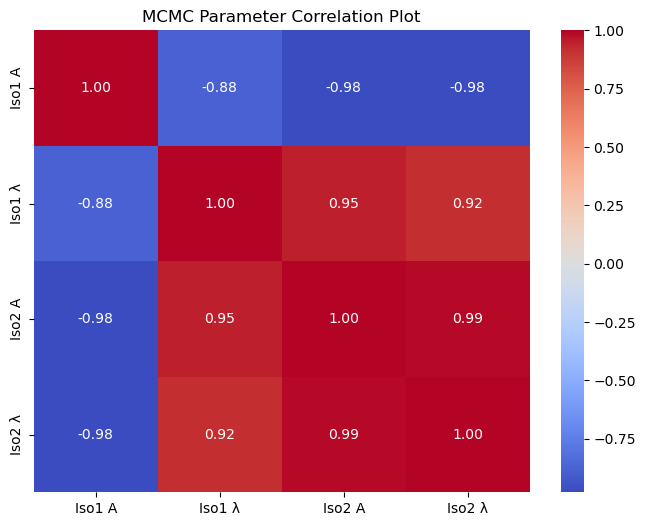

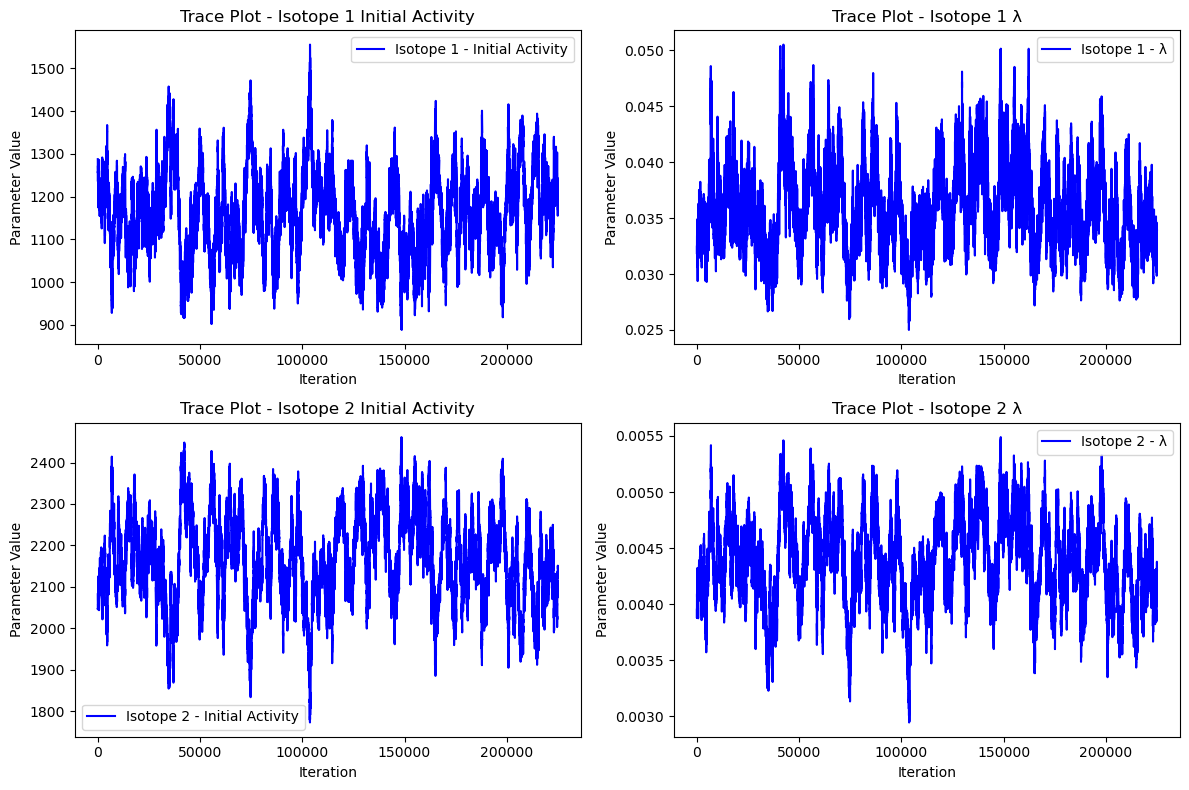

In [6]:
#MCMC Correlation and Trace plots
 
chain = chain1 #chain1 can be changed to chain2, 3 or 4 to get correlation and trace plots for other datasets

correlation_matrix = np.corrcoef(chain, rowvar=False)

plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=["Iso1 A", "Iso1 λ", "Iso2 A", "Iso2 λ"],
            yticklabels=["Iso1 A", "Iso1 λ", "Iso2 A", "Iso2 λ"])

plt.title("MCMC Parameter Correlation Plot")
plt.show()

plt.figure(figsize=(12, 8))

# Trace plot for Isotope 1 - Initial Activity
plt.subplot(2, 2, 1)
plt.plot(chain[:, 0], label='Isotope 1 - Initial Activity', color='blue')
plt.title('Trace Plot - Isotope 1 Initial Activity')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Trace plot for Isotope 1 - λ
plt.subplot(2, 2, 2)
plt.plot(chain[:, 1], label='Isotope 1 - λ', color='blue')
plt.title('Trace Plot - Isotope 1 λ')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Trace plot for Isotope 2 - Initial Activity
plt.subplot(2, 2, 3)
plt.plot(chain[:, 2], label='Isotope 2 - Initial Activity', color='blue')
plt.title('Trace Plot - Isotope 2 Initial Activity')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

# Trace plot for Isotope 2 - λ
plt.subplot(2, 2, 4)
plt.plot(chain[:, 3], label='Isotope 2 - λ', color='blue')
plt.title('Trace Plot - Isotope 2 λ')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()

plt.tight_layout()
plt.show()

Power relation between Activity and Distance = -2.0179385361717075 ± 0.2168889812636854
Power relation between Activity and Distance = -1.9802679777482222 ± 0.08254673587497685


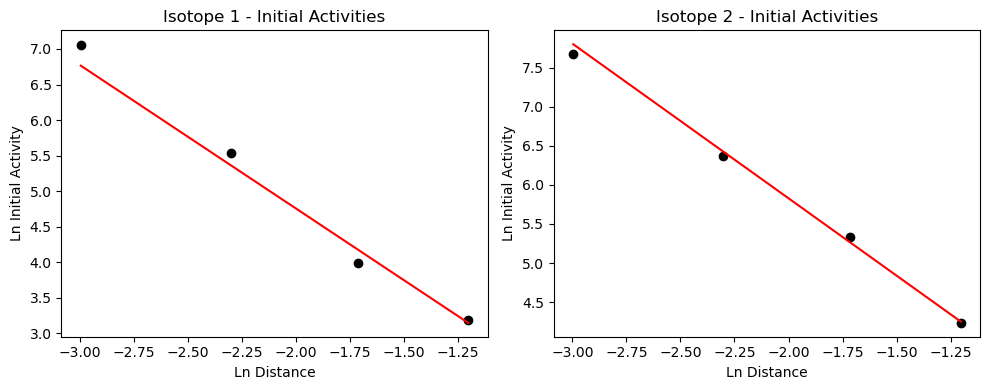

In [7]:
#ACTIVITY AS A FUNCTION OF DISTANCE
#ISOTOPE 1
#Ln Initial activities and Ln distances calculated with errors
A_list = np.log([isotope1_mcmc_c1, isotope1_mcmc_c2, isotope1_mcmc_c3, isotope1_mcmc_c4]) 
dist = [0.05, 0.1, 0.18, 0.3]
dist_error = np.ones(4) * 0.0005
ln_dist = np.log(dist)
e_ln_dist = dist_error/dist

#Least squares fit performed on Ln activities vs Ln distances
#Parameters are bootstrapped with mean and standard deviations taken
#Power law index taken as the gradient with standard deviation as uncertainty
S_d, sum_x_d, sum_y_d, sum_xx_d, sum_xy_d = chi_sums(ln_dist, A_list, e_ln_dist)
m_d = grad(S_d, sum_x_d, sum_y_d, sum_xx_d, sum_xy_d)
c_d = intercept(S_d, sum_x_d, sum_y_d, sum_xx_d, sum_xy_d)

fit_d = m_d*ln_dist + c_d
res_d = A_list - fit_d

boot_d = bootstrap(ln_dist, A_list, e_ln_dist, fit_d, res_d, 1000)
std_m_d = boot_d[2]

#Repeated using initial activities from isotope 2
#ISOTOPE 2
A_list2 = np.log([isotope2_mcmc_c1, isotope2_mcmc_c2, isotope2_mcmc_c3, isotope2_mcmc_c4])

S_d2, sum_x_d2, sum_y_d2, sum_xx_d2, sum_xy_d2 = chi_sums(ln_dist, A_list2, e_ln_dist)
m_d2 = grad(S_d2, sum_x_d2, sum_y_d2, sum_xx_d2, sum_xy_d2)
c_d2 = intercept(S_d2, sum_x_d2, sum_y_d2, sum_xx_d2, sum_xy_d2)

fit_d2 = m_d2*ln_dist + c_d2
res_d2 = A_list2 - fit_d2

boot_d2 = bootstrap(ln_dist, A_list2, e_ln_dist, fit_d2, res_d2, 1000)
std_m_d2 = boot_d2[2]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(ln_dist, A_list, color = 'black')
axs[0].errorbar(ln_dist, A_list, e_ln_dist, linestyle = '', color = 'black')
axs[0].plot(ln_dist, fit_d, color = 'red')
axs[0].set_xlabel('Ln Distance')
axs[0].set_ylabel('Ln Initial Activity')
axs[0].set_title('Isotope 1 - Initial Activities')

axs[1].scatter(ln_dist, A_list2, color = 'black')
axs[1].errorbar(ln_dist, A_list2, e_ln_dist, linestyle = '', color = 'black')
axs[1].plot(ln_dist, fit_d2, color = 'red')
axs[1].set_xlabel('Ln Distance')
axs[1].set_ylabel('Ln Initial Activity')
axs[1].set_title('Isotope 2 - Initial Activities')

plt.tight_layout()

print('Power relation between Activity and Distance = ' + str(m_d) + ' ' + u"\u00B1" + ' ' + str(std_m_d))
print('Power relation between Activity and Distance = ' + str(m_d2) + ' ' + u"\u00B1" + ' ' + str(std_m_d2))

In [8]:
# #PRINT STATEMENTS FOR DECAY CONSTANT AND INITIAL ACTIVITY - ONE ISOTOPE
# print('ONE ISOTOPE - PARAMETERS FROM INITIAL LEAST SQUARES FIT')
# print('Dataset 1: Decay Constant = ' + str(-m1))
# print('Dataset 1: Intercept = ' + str(c1))
# print('Dataset 1: Chi Squared = ' + str(chi2_1))
# print("\n")
# print('Dataset 2: Decay Constant = ' + str(-m2)) 
# print('Dataset 2: Intercept = ' + str(c2))
# print('Dataset 2: Chi Squared = ' + str(chi2_2))
# print("\n")
# print('Dataset 3: Decay Constant = ' + str(-m3)) 
# print('Dataset 3: Intercept = ' + str(c3))
# print('Dataset 3: Chi Squared = ' + str(chi2_3))
# print("\n")
# print('Dataset 4: Decay Constant = ' + str(-m4))  
# print('Dataset 4: Intercept = ' + str(c4))
# print('Dataset 4: Chi Squared = ' + str(chi2_4))

In [9]:
#PRINT STATEMENTS, MIN CHI2 FOR EACH DATASET WITH CORRESPONDING M AND C - ONE ISOTOPE
print('ONE ISOTOPE - BEST FIT PARAMETERS (GRID METHOD)')
print('Grid 1: Chi Squared = ' + str(min_chi2_1))
print('Grid 1: Gradient/Decay Constant = ' + str(np.abs(m1_list[m1_index])) + ' ' + u"\u00B1" + ' ' + str(m1_unc))
print('Grid 1: Intercept = ' + str(c1_list[c1_index]) + ' ' + u"\u00B1" + ' ' + str(c1_unc))
print('Grid 1: Initial Activity = ' + str(np.exp(c1_list[c1_index])) + ' ' + u"\u00B1" + ' ' + str(np.exp(c1_list[c1_index])*c1_unc))
print("\n")
print('Grid 2: Chi Squared = ' + str(min_chi2_2))
print('Grid 2: Gradient/Decay Constant = ' + str(np.abs(m2_list[m2_index])) + ' ' + u"\u00B1" + ' ' + str(m2_unc))
print('Grid 2: Intercept = ' + str(c2_list[c2_index]) + ' ' + u"\u00B1" + ' ' + str(c2_unc))
print('Grid 2: Initial Activity = ' + str(np.exp(c2_list[c2_index])) + ' ' + u"\u00B1" + ' ' + str(np.exp(c2_list[c2_index])*c2_unc))
print("\n")
print('Grid 3: Chi Squared = ' + str(min_chi2_3))
print('Grid 3: Gradient/Decay Constant = ' + str(np.abs(m3_list[m3_index])) + ' ' + u"\u00B1" + ' ' + str(m3_unc))
print('Grid 3: Intercept = ' + str(c3_list[c3_index]) + ' ' + u"\u00B1" + ' ' + str(c3_unc))
print('Grid 3: Initial Activity = ' + str(np.exp(c3_list[c3_index])) + ' ' + u"\u00B1" + ' ' + str(np.exp(c3_list[c3_index])*c3_unc))
print("\n")
print('Grid 4: Chi Squared = ' + str(min_chi2_4))
print('Grid 4: Gradient/Decay Constant = ' + str(np.abs(m4_list[m4_index])) + ' ' + u"\u00B1" + ' ' + str(m4_unc))
print('Grid 4: Intercept = ' + str(c4_list[c4_index]) + ' ' + u"\u00B1" + ' ' + str(c4_unc))
print('Grid 4: Initial Activity = ' + str(np.exp(c4_list[c4_index])) + ' ' + u"\u00B1" + ' ' + str(np.exp(c4_list[c4_index])*c4_unc))

ONE ISOTOPE - BEST FIT PARAMETERS (GRID METHOD)
Grid 1: Chi Squared = 683.8029319877595
Grid 1: Gradient/Decay Constant = 0.007569605697655955 ± 9.150517810849971e-05
Grid 1: Intercept = 8.003783086134932 ± 0.007798567211690255
Grid 1: Initial Activity = 2992.256566145106 ± 23.335313945704094


Grid 2: Chi Squared = 255.83502860566165
Grid 2: Gradient/Decay Constant = 0.007644751539304946 ± 0.00022669288942436458
Grid 2: Intercept = 6.615085685002081 ± 0.014604782889858114
Grid 2: Initial Activity = 746.2686716289287 ± 10.899091926643322


Grid 3: Chi Squared = 116.47910959604684
Grid 3: Gradient/Decay Constant = 0.007527472520691878 ± 0.00036931578895555133
Grid 3: Intercept = 5.447681413524856 ± 0.02363314570338204
Grid 3: Initial Activity = 232.21912112466597 ± 5.488068324650554


Grid 4: Chi Squared = 103.25959881124561
Grid 4: Gradient/Decay Constant = 0.007540223726509487 ± 0.0006380094250900102
Grid 4: Intercept = 4.41294045635734 ± 0.041204885480826015
Grid 4: Initial Activity 

In [10]:
#PRINT STATEMENTS FOR ONE ISOTOPE FIT HALF LIVES
print('ONE ISOTOPE - HALF LIVES')
print('Dataset 1: Half Life = ' + str(t_half1) + ' ' + u"\u00B1" + ' ' + str(t_half_unc1))
print('Dataset 2: Half Life = ' + str(t_half2) + ' ' + u"\u00B1" + ' ' + str(t_half_unc2))
print('Dataset 3: Half Life = ' + str(t_half3) + ' ' + u"\u00B1" + ' ' + str(t_half_unc3))
print('Dataset 4: Half Life = ' + str(t_half4) + ' ' + u"\u00B1" + ' ' + str(t_half_unc4))

ONE ISOTOPE - HALF LIVES
Dataset 1: Half Life = 91.5697868879206 ± 1.106941364347585
Dataset 2: Half Life = 90.66968062940677 ± 2.6886644751483093
Dataset 3: Half Life = 92.08232625952324 ± 4.517778959394003
Dataset 4: Half Life = 91.92660665001466 ± 7.778289290416265


In [11]:
#PRINT STATEMENTS BEST FIT PARAMETERS FOR TWO ISOTOPE FIT
print('TWO ISOTOPE - FIT PARAMETERS FROM SCIPY')
print('Dataset 1: Initial Activity - Isotope 1 = ' + str(A1_1))
print('Dataset 1: Decay Constant - Isotope 1 = ' + str(lambda1_1))
print('Dataset 1: Initial Activity - Isotope 2 = ' + str(A2_1))
print('Dataset 1: Decay Constant - Isotope 2 = ' + str(lambda2_1))
print('Dataset 1: Chi Squared = ' + str(chi2_two_isotope1))
print("\n")
print('Dataset 2: Initial Activity - Isotope 1 = ' + str(A1_2))
print('Dataset 2: Decay Constant - Isotope 1 = ' + str(lambda1_2))
print('Dataset 2: Initial Activity - Isotope 2 = ' + str(A2_2))
print('Dataset 2: Decay Constant - Isotope 2 = ' + str(lambda2_2))
print('Dataset 2: Chi Squared = ' + str(chi2_two_isotope2))
print("\n")
print('Dataset 3: Initial Activity - Isotope 1 = ' + str(A1_3))
print('Dataset 3: Decay Constant - Isotope 1 = ' + str(lambda1_3))
print('Dataset 3: Initial Activity - Isotope 2 = ' + str(A2_3))
print('Dataset 3: Decay Constant - Isotope 2 = ' + str(lambda2_3))
print('Dataset 3: Chi Squared = ' + str(chi2_two_isotope3))
print("\n")
print('Dataset 4: Initial Activity - Isotope 1 = ' + str(A1_4))
print('Dataset 4: Decay Constant - Isotope 1 = ' + str(lambda1_4))
print('Dataset 4: Initial Activity - Isotope 2 = ' + str(A2_4))
print('Dataset 4: Decay Constant - Isotope 2 = ' + str(lambda2_4))
print('Dataset 4: Chi Squared = ' + str(chi2_two_isotope4))

TWO ISOTOPE - FIT PARAMETERS FROM SCIPY
Dataset 1: Initial Activity - Isotope 1 = 1160.8262445140213
Dataset 1: Decay Constant - Isotope 1 = 0.03538231070446729
Dataset 1: Initial Activity - Isotope 2 = 2166.352319383459
Dataset 1: Decay Constant - Isotope 2 = 0.0043858144789574085
Dataset 1: Chi Squared = 114.80448269268376


Dataset 2: Initial Activity - Isotope 1 = 579.2048468272033
Dataset 2: Decay Constant - Isotope 1 = 0.005034290958187996
Dataset 2: Initial Activity - Isotope 2 = 259.09497414382815
Dataset 2: Decay Constant - Isotope 2 = 0.04296301912589746
Dataset 2: Chi Squared = 110.49580495774988


Dataset 3: Initial Activity - Isotope 1 = 201.6949926495713
Dataset 3: Decay Constant - Isotope 1 = 0.00604175278798981
Dataset 3: Initial Activity - Isotope 2 = 55.18708304710162
Dataset 3: Decay Constant - Isotope 2 = 0.05888280931828123
Dataset 3: Chi Squared = 87.85920162160994


Dataset 4: Initial Activity - Isotope 1 = 67.46255714637059
Dataset 4: Decay Constant - Isotope 1 

In [12]:
#PRINT STATEMENTS FOR MCMC
print('TWO ISOTOPE - BEST FIT PARAMETERS FROM MCMC, median and 16 - 84% CI')
print('Dataset 1: Isotope 1 Median Decay Constant = ' + str(isotope1_mcmc_m1) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_m1))
print('Dataset 1: Isotope 1 Median Initial Activity = ' + str(isotope1_mcmc_c1) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_c1))
print('Dataset 1: Isotope 2 Median Decay Constant = ' + str(isotope2_mcmc_m1) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_m1))
print('Dataset 1: Isotope 2 Median Initial Activity = ' + str(isotope2_mcmc_c1) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_c1))
print("\n")
print('Dataset 2: Isotope 1 Median Decay Constant = ' + str(isotope1_mcmc_m2) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_m2))
print('Dataset 2: Isotope 1 Median Initial Activity = ' + str(isotope1_mcmc_c2) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_c2))
print('Dataset 2: Isotope 2 Median Decay Constant = ' + str(isotope2_mcmc_m2) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_m2))
print('Dataset 2: Isotope 2 Median Initial Activity = ' + str(isotope2_mcmc_c2) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_c2))
print("\n")
print('Dataset 3: Isotope 1 Median Decay Constant = ' + str(isotope1_mcmc_m3) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_m3))
print('Dataset 3: Isotope 1 Median Initial Activity = ' + str(isotope1_mcmc_c3) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_c3))
print('Dataset 3: Isotope 2 Median Decay Constant = ' + str(isotope2_mcmc_m3) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_m3))
print('Dataset 3: Isotope 2 Median Initial Activity = ' + str(isotope2_mcmc_c3) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_c3))
print("\n")
print('Dataset 4: Isotope 1 Median Decay Constant = ' + str(isotope1_mcmc_m4) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_m4))
print('Dataset 4: Isotope 1 Median Initial Activity = ' + str(isotope1_mcmc_c4) + ' ' + u"\u00B1" + ' ' + str(isotope1_CI_c4))
print('Dataset 4: Isotope 2 Median Decay Constant = ' + str(isotope2_mcmc_m4) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_m4))
print('Dataset 4: Isotope 2 Median Initial Activity = ' + str(isotope2_mcmc_c4) + ' ' + u"\u00B1" + ' ' + str(isotope2_CI_c4))

TWO ISOTOPE - BEST FIT PARAMETERS FROM MCMC, median and 16 - 84% CI
Dataset 1: Isotope 1 Median Decay Constant = 0.03538670878893161 ± [0.0033207766987696577, 0.0043488467030383185]
Dataset 1: Isotope 1 Median Initial Activity = 1160.3995032291448 ± [101.31646650188554, 100.05657366995274]
Dataset 1: Isotope 2 Median Decay Constant = 0.004388112013142006 ± [0.00039240434916971295, 0.00040420114333137355]
Dataset 1: Isotope 2 Median Initial Activity = 2166.3378424209886 ± [108.52604840058575, 113.10182936213869]


Dataset 2: Isotope 1 Median Decay Constant = 0.04433192166974193 ± [0.007750195726671176, 0.008131589486430946]
Dataset 2: Isotope 1 Median Initial Activity = 254.90418649088238 ± [27.928735865001215, 37.48322272924477]
Dataset 2: Isotope 2 Median Decay Constant = 0.005128815233544357 ± [0.0006304517012005418, 0.0004429888361847179]
Dataset 2: Isotope 2 Median Initial Activity = 585.6815387962595 ± [42.64098812569341, 28.926554293476784]


Dataset 3: Isotope 1 Median Decay Con

In [13]:
#TWO ISOTOPE - HALF LIVES
print('TWO ISOTOPE - HALF LIVES')
print('Dataset 1: Isotope 1 Half Life = ' + str(iso1_t_half1) + ' ' + u"\u00B1" + ' ' + str(iso1_t_half_unc1)) 
print('Dataset 1: Isotope 2 Half Life = ' + str(iso2_t_half1) + ' ' + u"\u00B1" + ' ' + str(iso2_t_half_unc1)) 
print("\n")
print('Dataset 2: Isotope 1 Half Life = ' + str(iso1_t_half2) + ' ' + u"\u00B1" + ' ' + str(iso1_t_half_unc2)) 
print('Dataset 2: Isotope 2 Half Life = ' + str(iso2_t_half2) + ' ' + u"\u00B1" + ' ' + str(iso2_t_half_unc2))
print("\n")
print('Dataset 3: Isotope 1 Half Life = ' + str(iso1_t_half3) + ' ' + u"\u00B1" + ' ' + str(iso1_t_half_unc3)) 
print('Dataset 3: Isotope 2 Half Life = ' + str(iso2_t_half3) + ' ' + u"\u00B1" + ' ' + str(iso2_t_half_unc3)) 
print("\n")
print('Dataset 4: Isotope 1 Half Life = ' + str(iso1_t_half4) + ' ' + u"\u00B1" + ' ' + str(iso1_t_half_unc4)) 
print('Dataset 4: Isotope 2 Half Life = ' + str(iso2_t_half4) + ' ' + u"\u00B1" + ' ' + str(iso2_t_half_unc4)) 

TWO ISOTOPE - HALF LIVES
Dataset 1: Isotope 1 Half Life = 19.587783218109013 ± [1.83816626 2.40723903]
Dataset 1: Isotope 2 Half Life = 157.96022947546257 ± [14.12550109 14.55015395]


Dataset 2: Isotope 1 Half Life = 15.635396672484923 ± [2.7334115  2.86792502]
Dataset 2: Isotope 2 Half Life = 135.1476216235097 ± [16.61281292 11.67304434]


Dataset 3: Isotope 1 Half Life = 9.76552077321052 ± [3.24028195 6.33219699]
Dataset 3: Isotope 2 Half Life = 110.1635362217431 ± [11.98636232  8.59824363]


Dataset 4: Isotope 1 Half Life = 11.322753316443578 ± [5.57734071 8.72340037]
Dataset 4: Isotope 2 Half Life = 119.01028218190099 ± [33.0610925  18.72830353]


In [14]:
#IDENTIFYING ISOTOPES
#Determined by subtracting calculated half life from known isotope half lives and finding the smallest difference. 
half_life_listnames = np.array(['Cesium_120', 'Cesium_121', 'Cesium_124', 'Barium_123', 'Barium_124', 'Barium_125', 'Barium_137', 'Europium_137', 'Europium_138', 'Europium_139', 'Europium_143', 'Tungsten_166', 'Tungsten_168', 'Tungsten_169', 'Neptunium_229', 'Neptunium_230', 'Neptunium_232'])
half_life_list = np.array([Cs_120, Cs_121, Cs_124, Ba_123, Ba_124, Ba_125, Ba_137, Eu_137, Eu_138, Eu_139, Eu_143, W_166, W_168, W_169, Np_229, Np_230, Np_232])

dataset_half_life1 = iso1_t_half1 #change to iso1_t_half2, 3 or 4 to identify isotopes using half lives from other datasets, currently set to dataset 1
dataset_half_life2 = iso2_t_half1 #change to iso2_t_half2, 3 or 4 to identify isotopes using half lives from other datasets, currently set to dataset 1

diff_list_iso1 = []
diff_list_iso2 = []

for i in half_life_list:
    half_life_diff = np.abs(dataset_half_life1 - i)
    diff_list_iso1.append(half_life_diff)

for i in half_life_list:
    half_life_diff = np.abs(dataset_half_life2 - i)
    diff_list_iso2.append(half_life_diff)

isotope1_index = diff_list_iso1.index(min(diff_list_iso1))
isotope1_half_life = half_life_list[isotope1_index]
isotope1_identity = half_life_listnames[isotope1_index]

isotope2_index = diff_list_iso2.index(min(diff_list_iso2))
isotope2_half_life = half_life_list[isotope2_index]
isotope2_identity = half_life_listnames[isotope2_index]

print('Isotope 1 = ' + ' ' + isotope1_identity)
print('Isotope 1 half life = ' + ' ' + str(isotope1_half_life))
print('Isotope 2 = ' + ' ' + isotope2_identity)
print('Isotope 2 half life = ' + ' ' + str(isotope2_half_life))

Isotope 1 =  Tungsten_166
Isotope 1 half life =  19.2
Isotope 2 =  Europium_143
Isotope 2 half life =  155.4


In [15]:
#PRINT STATEMENTS REDUCED CHI2, AIC, AIC_CORR AND BIC
print('CHI SQUARED, AIC, BIC COMPARISON BETWEEN ONE AND TWO ISOTOPE FITS')
print('Dataset 1: Chi Squared one isotope = ' + str(chi2_1))
print('Dataset 1: Chi Squared two isotope = ' + str(mcmc_chi2_min1))
print('Dataset 1: Reduced Chi2 for one isotope = ' + str(chi_reduced_1))
print('Dataset 1: Reduced Chi2 for two isotope = ' + str(two_isotope_chi_reduced_1))
print('Dataset 1: AIC for one isotope = ' + str(AIC_1))
print('Dataset 1: AIC for two isotope = ' + str(two_isotope_AIC_1))
print('Dataset 1: AIC corrected for one isotope = ' + str(AIC_corr_1)) 
print('Dataset 1: AIC corrected for two isotope = ' + str(two_isotope_AIC_corr_1))
print('Dataset 1: BIC for one isotope = ' + str(BIC_1))
print('Dataset 1: BIC for two isotope = ' + str(two_isotope_BIC_1))
print("\n")
print('Dataset 2: Chi Squared one isotope = ' + str(chi2_2))
print('Dataset 2: Chi Squared two isotope = ' + str(mcmc_chi2_min2))
print('Dataset 2: Reduced Chi2 for one isotope = ' + str(chi_reduced_2))
print('Dataset 2: Reduced Chi2 for two isotope = ' + str(two_isotope_chi_reduced_2))
print('Dataset 2: AIC for one isotope = ' + str(AIC_2))
print('Dataset 2: AIC for two isotope = ' + str(two_isotope_AIC_2))
print('Dataset 2: AIC corrected for one isotope = ' + str(AIC_corr_2)) 
print('Dataset 2: AIC corrected for two isotope = ' + str(two_isotope_AIC_corr_2))
print('Dataset 2: BIC for one isotope = ' + str(BIC_2))
print('Dataset 2: BIC for two isotope = ' + str(two_isotope_BIC_2))
print("\n")
print('Dataset 3: Chi Squared one isotope = ' + str(chi2_3))
print('Dataset 3: Chi Squared two isotope = ' + str(mcmc_chi2_min3))
print('Dataset 3: Reduced Chi2 for one isotope = ' + str(chi_reduced_3))
print('Dataset 3: Reduced Chi2 for two isotope = ' + str(two_isotope_chi_reduced_3))
print('Dataset 3: AIC for one isotope = ' + str(AIC_3))
print('Dataset 3: AIC for two isotope = ' + str(two_isotope_AIC_3))
print('Dataset 3: AIC corrected for one isotope = ' + str(AIC_corr_3)) 
print('Dataset 3: AIC corrected for two isotope = ' + str(two_isotope_AIC_corr_3))
print('Dataset 3: BIC for one isotope = ' + str(BIC_3))
print('Dataset 3: BIC for two isotope = ' + str(two_isotope_BIC_3))
print("\n")
print('Dataset 4: Chi Squared one isotope = ' + str(chi2_4))
print('Dataset 4: Chi Squared two isotope = ' + str(mcmc_chi2_min4))
print('Dataset 4: Reduced Chi2 for one isotope = ' + str(chi_reduced_4))
print('Dataset 4: Reduced Chi2 for two isotope = ' + str(two_isotope_chi_reduced_4))
print('Dataset 4: AIC for one isotope = ' + str(AIC_4))
print('Dataset 4: AIC for two isotope = ' + str(two_isotope_AIC_4))
print('Dataset 4: AIC corrected for one isotope = ' + str(AIC_corr_4)) 
print('Dataset 4: AIC corrected for two isotope = ' + str(two_isotope_AIC_corr_4))
print('Dataset 4: BIC for one isotope = ' + str(BIC_4))
print('Dataset 4: BIC for two isotope = ' + str(two_isotope_BIC_4))
print("\n")

CHI SQUARED, AIC, BIC COMPARISON BETWEEN ONE AND TWO ISOTOPE FITS
Dataset 1: Chi Squared one isotope = 683.7185408947028
Dataset 1: Chi Squared two isotope = 114.81350457123607
Dataset 1: Reduced Chi2 for one isotope = 6.977580938650608
Dataset 1: Reduced Chi2 for two isotope = 1.1959740059503756
Dataset 1: AIC for one isotope = 687.8029319877595
Dataset 1: AIC for two isotope = 122.81350457123607
Dataset 1: AIC corrected for one isotope = 687.9266433279657
Dataset 1: AIC corrected for two isotope = 123.23455720281501
Dataset 1: BIC for one isotope = 693.0132723597357
Dataset 1: BIC for two isotope = 133.23418531518843


Dataset 2: Chi Squared one isotope = 255.80261440631952
Dataset 2: Chi Squared two isotope = 110.55895125399572
Dataset 2: Reduced Chi2 for one isotope = 2.6105615163843026
Dataset 2: Reduced Chi2 for two isotope = 1.151655742229122
Dataset 2: AIC for one isotope = 259.83502860566165
Dataset 2: AIC for two isotope = 118.55895125399572
Dataset 2: AIC corrected for one i

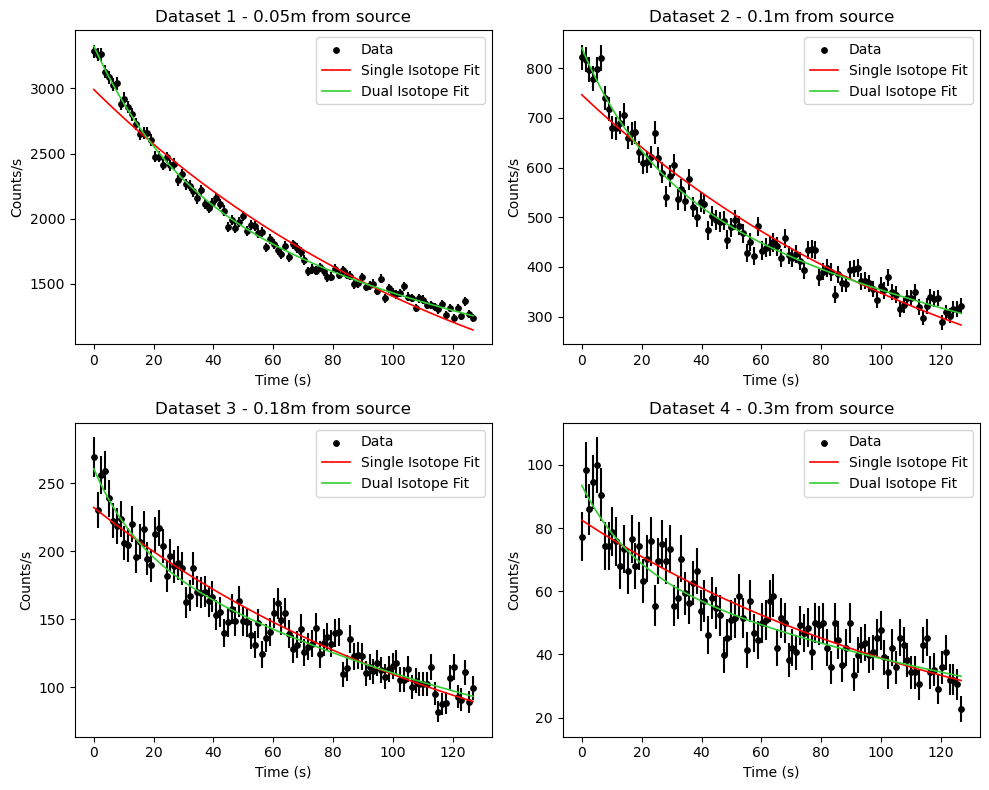

In [16]:
#PLOTS - Exponential fits to Counts vs Time - One and Two Isotope Models
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# # Plot for Dataset 1
axs[0, 0].scatter(x_data, y1_raw, s=15, color='black', label='Data')
axs[0, 0].errorbar(x_data, y1_raw, y1_error_raw, linestyle='', color='black')
axs[0, 0].plot(x_data, one_isotope_fit1, color='red', linewidth=1.2, label = 'Single Isotope Fit')
axs[0, 0].plot(x_data, mcmc_fit1, color='limegreen', linewidth=1.2, label = 'Dual Isotope Fit')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Counts/s')
axs[0, 0].set_title('Dataset 1 - 0.05m from source')
axs[0, 0].legend(loc='upper right')

# Plot for Dataset 2
axs[0, 1].scatter(x_data, y2_raw, s=15, color='black', label='Data')
axs[0, 1].errorbar(x_data, y2_raw, y2_error_raw, linestyle='', color='black')
axs[0, 1].plot(x_data, one_isotope_fit2, color='red', linewidth=1.2, label = 'Single Isotope Fit')
axs[0, 1].plot(x_data, mcmc_fit2, color='limegreen', linewidth=1.2, label = 'Dual Isotope Fit')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Counts/s')
axs[0, 1].set_title('Dataset 2 - 0.1m from source')
axs[0, 1].legend(loc='upper right')

# Plot for Dataset 3
axs[1, 0].scatter(x_data, y3_raw, s=15, color='black', label='Data')
axs[1, 0].errorbar(x_data, y3_raw, y3_error_raw, linestyle='', color='black')
axs[1, 0].plot(x_data, one_isotope_fit3, color='red', linewidth=1.2, label = 'Single Isotope Fit')
axs[1, 0].plot(x_data, mcmc_fit3, color='limegreen', linewidth=1.2, label = 'Dual Isotope Fit')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Counts/s')
axs[1, 0].set_title('Dataset 3 - 0.18m from source')
axs[1, 0].legend(loc='upper right')

# Plot for Dataset 4
axs[1, 1].scatter(x_data, y4_raw, s=15, color='black', label='Data')
axs[1, 1].errorbar(x_data, y4_raw, y4_error_raw, linestyle='', color='black')
axs[1, 1].plot(x_data, one_isotope_fit4, color='red', linewidth=1.2, label = 'Single Isotope Fit')
axs[1, 1].plot(x_data, mcmc_fit4, color='limegreen', linewidth=1.2, label = 'Dual Isotope Fit')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Counts/s')
axs[1, 1].set_title('Dataset 4 - 0.3m from source')
axs[1, 1].legend(loc='upper right')

plt.tight_layout()


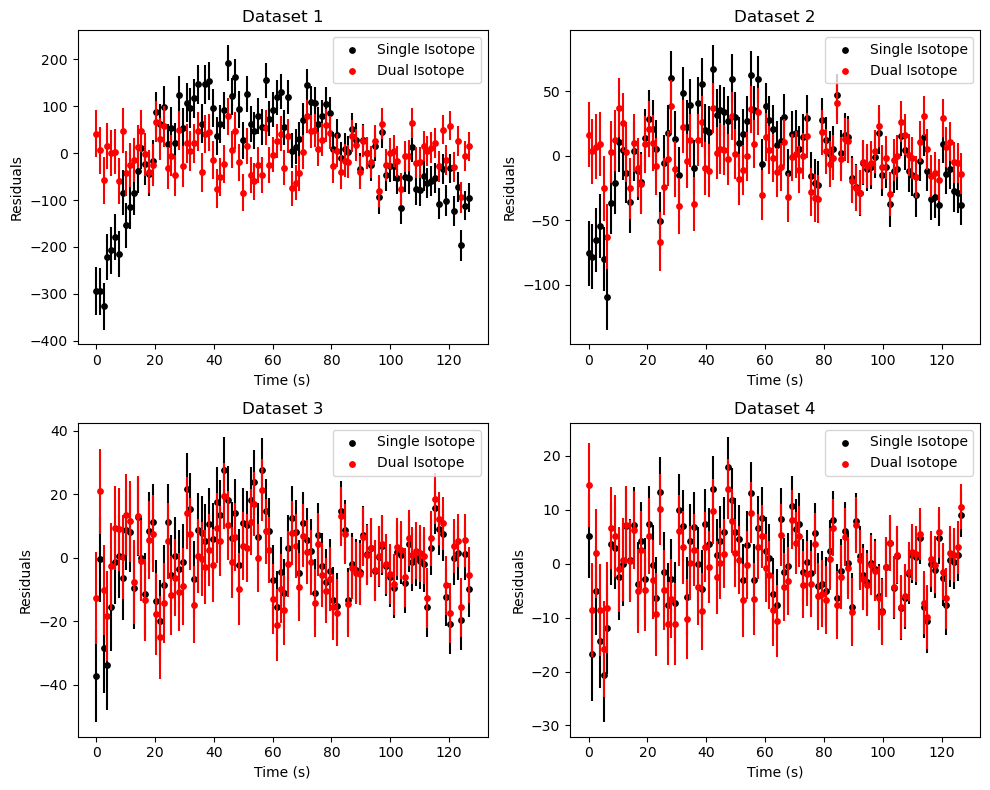

In [17]:
#RESIDUAL PLOTS
fig1, axs1 = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot for Dataset 1
axs1[0, 0].scatter(x_data, one_isotope_res1, s=15, color='black', label = 'Single Isotope')
axs1[0, 0].errorbar(x_data, one_isotope_res1, y1_error_raw, linestyle='', color='black')
axs1[0, 0].scatter(x_data, two_isotope_res1, s=15, color='red', label = 'Dual Isotope')
axs1[0, 0].errorbar(x_data, two_isotope_res1, y1_error_raw, linestyle='', color='red')
axs1[0, 0].set_xlabel('Time (s)')
axs1[0, 0].set_ylabel('Residuals')
axs1[0, 0].set_title('Dataset 1')
axs1[0, 0].legend(loc='upper right')

# Plot for Dataset 2
axs1[0, 1].scatter(x_data, one_isotope_res2, s=15, color='black', label = 'Single Isotope')
axs1[0, 1].errorbar(x_data, one_isotope_res2, y2_error_raw, linestyle='', color='black')
axs1[0, 1].scatter(x_data, two_isotope_res2, s=15, color='red', label = 'Dual Isotope')
axs1[0, 1].errorbar(x_data, two_isotope_res2, y2_error_raw, linestyle='', color='red')
axs1[0, 1].set_xlabel('Time (s)')
axs1[0, 1].set_ylabel('Residuals')
axs1[0, 1].set_title('Dataset 2')
axs1[0, 1].legend(loc='upper right')

# Plot for Dataset 3
axs1[1, 0].scatter(x_data, one_isotope_res3, s=15, color='black', label = 'Single Isotope' )
axs1[1, 0].errorbar(x_data, one_isotope_res3, y3_error_raw, linestyle='', color='black')
axs1[1, 0].scatter(x_data, two_isotope_res3, s=15, color='red', label = 'Dual Isotope')
axs1[1, 0].errorbar(x_data, two_isotope_res3, y3_error_raw, linestyle='', color='red')
axs1[1, 0].set_xlabel('Time (s)')
axs1[1, 0].set_ylabel('Residuals')
axs1[1, 0].set_title('Dataset 3')
axs1[1, 0].legend(loc='upper right')

# Plot for Dataset 4
axs1[1, 1].scatter(x_data, one_isotope_res4, s=15, color='black', label = 'Single Isotope')
axs1[1, 1].errorbar(x_data, one_isotope_res4, y4_error_raw, linestyle='', color='black')
axs1[1, 1].scatter(x_data, two_isotope_res4, s=15, color='red', label = 'Dual Isotope')
axs1[1, 1].errorbar(x_data, two_isotope_res4, y4_error_raw, linestyle='', color='red')
axs1[1, 1].set_xlabel('Time (s)')
axs1[1, 1].set_ylabel('Residuals')
axs1[1, 1].set_title('Dataset 4')
axs1[1, 1].legend(loc='upper right')

plt.tight_layout()

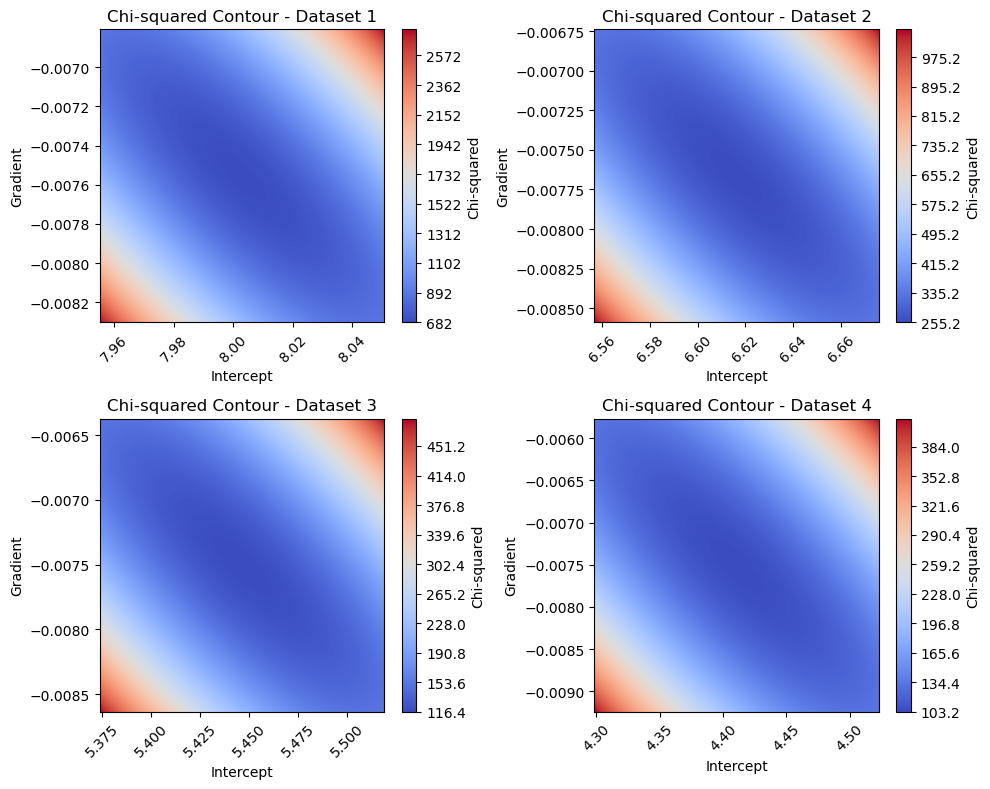

In [18]:
# #GRID PLOTS - Uncertainties in Parameters for One Isotope Fit
fig2, axs2 = plt.subplots(2, 2, figsize=(10, 8))

# Plot for Dataset 1
contour1 = axs2[0, 0].contourf(c1_list, m1_list, chi2_grid1, levels=1000, cmap='coolwarm')
axs2[0, 0].set_xlabel('Intercept')
axs2[0, 0].set_ylabel('Gradient')
axs2[0, 0].set_title('Chi-squared Contour - Dataset 1')
fig2.colorbar(contour1, ax=axs2[0, 0], label='Chi-squared')
axs2[0, 0].tick_params(axis='x', rotation=45)  

# Plot for Dataset 2
contour2 = axs2[0, 1].contourf(c2_list, m2_list, chi2_grid2, levels=1000, cmap='coolwarm')
axs2[0, 1].set_xlabel('Intercept')
axs2[0, 1].set_ylabel('Gradient')
axs2[0, 1].set_title('Chi-squared Contour - Dataset 2')
fig2.colorbar(contour2, ax=axs2[0, 1], label='Chi-squared')
axs2[0, 1].tick_params(axis='x', rotation=45)  

# Plot for Dataset 3
contour3 = axs2[1, 0].contourf(c3_list, m3_list, chi2_grid3, levels=1000, cmap='coolwarm')
axs2[1, 0].set_xlabel('Intercept')
axs2[1, 0].set_ylabel('Gradient')
axs2[1, 0].set_title('Chi-squared Contour - Dataset 3')
fig2.colorbar(contour3, ax=axs2[1, 0], label='Chi-squared')
axs2[1, 0].tick_params(axis='x', rotation=45)  

# Plot for Dataset 4
contour4 = axs2[1, 1].contourf(c4_list, m4_list, chi2_grid4, levels=1000, cmap='coolwarm')
axs2[1, 1].set_xlabel('Intercept')
axs2[1, 1].set_ylabel('Gradient')
axs2[1, 1].set_title('Chi-squared Contour - Dataset 4')
fig2.colorbar(contour4, ax=axs2[1, 1], label='Chi-squared')
axs2[1, 1].tick_params(axis='x', rotation=45)  

plt.tight_layout()

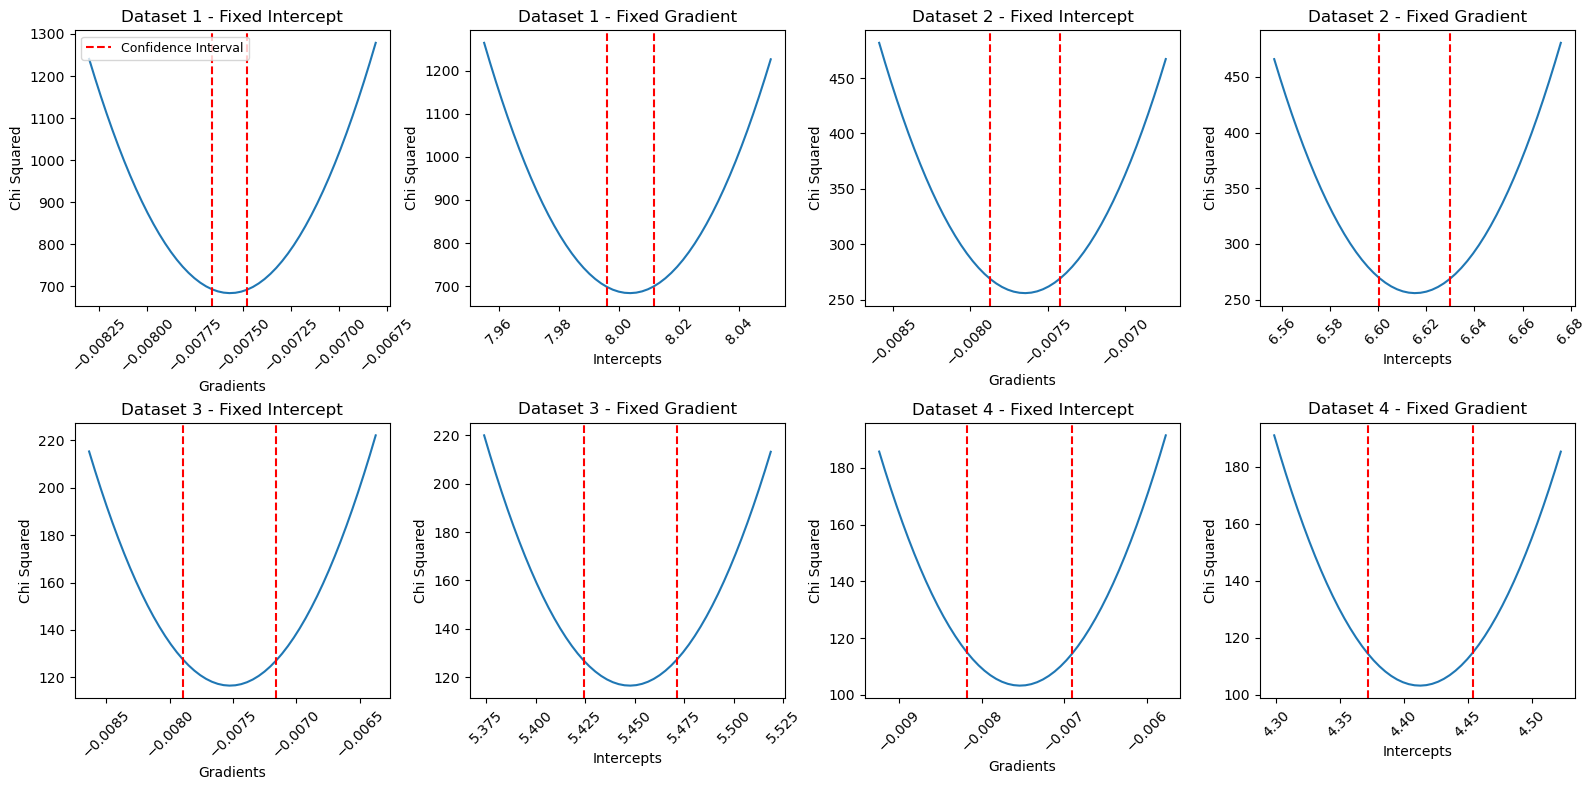

In [19]:
#CHI2 WITH ONE PARAMETER FIXED - One Isotope
fig3, axs3 = plt.subplots(2, 4, figsize=(16, 8))

# Dataset 1
axs3[0, 0].plot(varying_m1, chi2_varying_m1)
axs3[0, 0].axvline(x = (best_fit_m1 - m1_unc), color = 'red', linestyle = 'dashed', label = 'Confidence Interval')
axs3[0, 0].axvline(x = (best_fit_m1 + m1_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 0].set_xlabel('Gradients')
axs3[0, 0].set_ylabel('Chi Squared')
axs3[0, 0].set_title('Dataset 1 - Fixed Intercept')
axs3[0, 0].tick_params(axis='x', rotation=45)
axs3[0, 0].legend(loc='upper left', fontsize = 9)

axs3[0, 1].plot(varying_c1, chi2_varying_c1)
axs3[0, 1].axvline(x = (best_fit_c1 - c1_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 1].axvline(x = (best_fit_c1 + c1_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 1].set_xlabel('Intercepts')
axs3[0, 1].set_ylabel('Chi Squared')
axs3[0, 1].set_title('Dataset 1 - Fixed Gradient')
axs3[0, 1].tick_params(axis='x', rotation=45)

# Dataset 2
axs3[0, 2].plot(varying_m2, chi2_varying_m2)
axs3[0, 2].axvline(x = (best_fit_m2 - m2_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 2].axvline(x = (best_fit_m2 + m2_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 2].set_xlabel('Gradients')
axs3[0, 2].set_ylabel('Chi Squared')
axs3[0, 2].set_title('Dataset 2 - Fixed Intercept')
axs3[0, 2].tick_params(axis='x', rotation=45)

axs3[0, 3].plot(varying_c2, chi2_varying_c2)
axs3[0, 3].axvline(x = (best_fit_c2 - c2_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 3].axvline(x = (best_fit_c2 + c2_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[0, 3].set_xlabel('Intercepts')
axs3[0, 3].set_ylabel('Chi Squared')
axs3[0, 3].set_title('Dataset 2 - Fixed Gradient')
axs3[0, 3].tick_params(axis='x', rotation=45)

# Dataset 3
axs3[1, 0].plot(varying_m3, chi2_varying_m3)
axs3[1, 0].axvline(x = (best_fit_m3 - m3_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 0].axvline(x = (best_fit_m3 + m3_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 0].set_xlabel('Gradients')
axs3[1, 0].set_ylabel('Chi Squared')
axs3[1, 0].set_title('Dataset 3 - Fixed Intercept')
axs3[1, 0].tick_params(axis='x', rotation=45)

axs3[1, 1].plot(varying_c3, chi2_varying_c3)
axs3[1, 1].axvline(x = (best_fit_c3 - c3_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 1].axvline(x = (best_fit_c3 + c3_unc), color = 'red', linestyle = 'dashed', label = 'axvline - full height')
axs3[1, 1].set_xlabel('Intercepts')
axs3[1, 1].set_ylabel('Chi Squared')
axs3[1, 1].set_title('Dataset 3 - Fixed Gradient')
axs3[1, 1].tick_params(axis='x', rotation=45)

# Dataset 4
axs3[1, 2].plot(varying_m4, chi2_varying_m4)
axs3[1, 2].axvline(x = (best_fit_m4 - m4_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 2].axvline(x = (best_fit_m4 + m4_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 2].set_xlabel('Gradients')
axs3[1, 2].set_ylabel('Chi Squared')
axs3[1, 2].set_title('Dataset 4 - Fixed Intercept')
axs3[1, 2].tick_params(axis='x', rotation=45)

axs3[1, 3].plot(varying_c4, chi2_varying_c4)
axs3[1, 3].axvline(x = (best_fit_c4 - c4_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 3].axvline(x = (best_fit_c4 + c4_unc), color = 'red', linestyle = 'dashed', label = '')
axs3[1, 3].set_xlabel('Intercepts')
axs3[1, 3].set_ylabel('Chi Squared')
axs3[1, 3].set_title('Dataset 4 - Fixed Gradient')
axs3[1, 3].tick_params(axis='x', rotation=45)

plt.tight_layout() 

<Figure size 640x480 with 0 Axes>

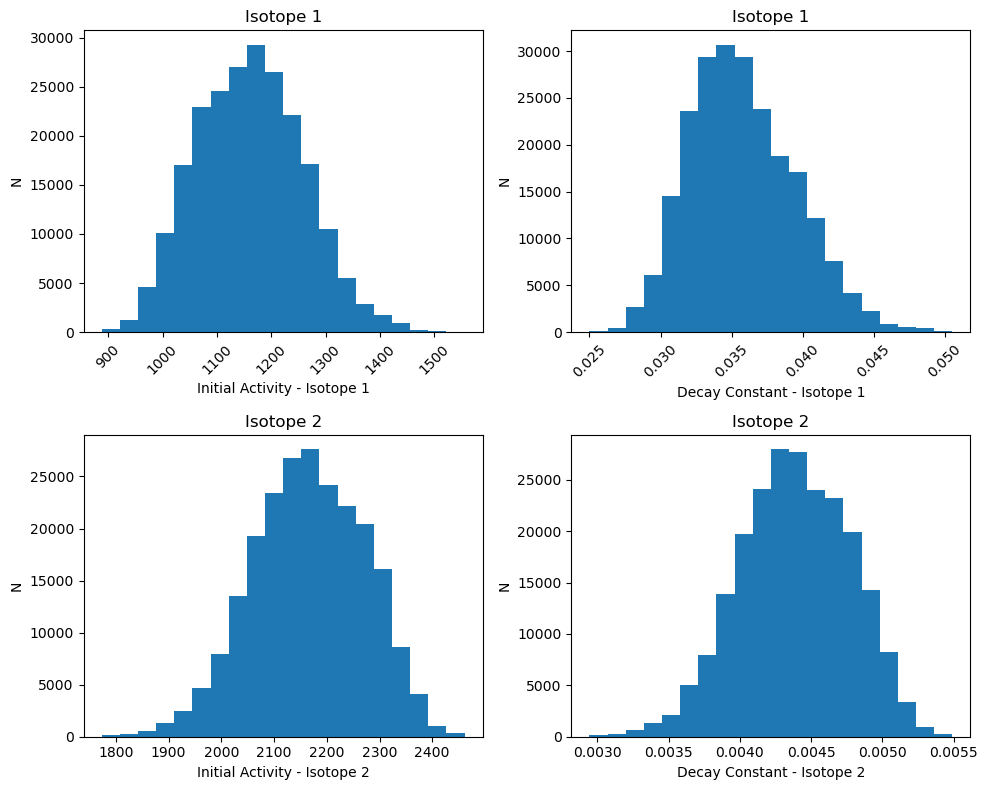

In [20]:
#Histograms for sampled parameters from MCMC

chain = chain1 #Chain from Dataset 1 - change chain1 to chain2, 3 or 4 for other datasets

plt.figure(2)
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

#Plot for Dataset 1
axs[0, 0].hist(chain[:, 0], bins = 20)
axs[0, 0].set_xlabel('Initial Activity - Isotope 1')
axs[0, 0].set_ylabel('N')
axs[0, 0].set_title('Isotope 1')
axs[0, 0].tick_params(axis='x', rotation=45)  

# Plot for Dataset 2
axs[0, 1].hist(chain[:, 1], bins = 20)
axs[0, 1].set_xlabel('Decay Constant - Isotope 1')
axs[0, 1].set_ylabel('N')
axs[0, 1].set_title('Isotope 1')
axs[0, 1].tick_params(axis='x', rotation=45)  

# Plot for Dataset 3
axs[1, 0].hist(chain[:, 2], bins = 20)
axs[1, 0].set_xlabel('Initial Activity - Isotope 2')
axs[1, 0].set_ylabel('N')
axs[1, 0].set_title('Isotope 2')

# Plot for Dataset 4
axs[1, 1].hist(chain[:, 3], bins = 20)
axs[1, 1].set_xlabel('Decay Constant - Isotope 2')
axs[1, 1].set_ylabel('N')
axs[1, 1].set_title('Isotope 2')

plt.tight_layout()